This notebook computes the accuracy of various precomputed outputs on each synthetic data set. 

In [98]:
import itertools

import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", FutureWarning)

In [100]:
plt.rcParams['pdf.fonttype'] = 42

In [3]:
def hex_to_rgb(h):
    return tuple(int(h[i+1:i+3], 16) for i in (0, 2, 4))

In [4]:
# Orderings of cell types in ground truth and TopACT-predicted data
# One is alphabetical, the other is by total number of cells in snRNA-seq
ACTUAL_CELLTYPES = ['PT', 'TAL', 'DCT', 'ENDO', 'VSM', 'CCD', 'IMMUNE', 'PODS', 'UROTHELIUM']
ALPHABETICAL_CELLTYPES = ['CCD', 'DCT', 'ENDO', 'IMMUNE', 'PODS', 'PT', 'TAL', 'UROTHELIUM', 'VSM']

In [75]:
# We store the accuracies of each iteration in these lists
topact_values = []
bin20_values = []
rctd_values = []

for i in range(100):
        
    # Ground truth cell types
    actual = np.loadtxt(f'../topact-data/syntheticdata/groundtruth/celltypegrid_{i}.txt')
    
    

    # TOPACT PREDICTIONS
    
    # Convert indices to match order of ground truth cell types
    def convert_topact(image):
        
        def convert_coord(p):
            x = image[p]
            if np.isnan(x):
                return -1 # Represents missing prediction
            return ACTUAL_CELLTYPES.index(ALPHABETICAL_CELLTYPES[int(x)])
        
        return np.array(list(map(convert_coord, itertools.product(range(500), range(500))))).reshape((500,500))
    
    # TopACT confidence matrix
    predicted = np.loadtxt(f'../topact-data/syntheticdata/topactpreds/topactpreds_{i}.txt')
    # Convert to ground truth cell type indices
    predicted = convert_topact(predicted)
    
    # This is the accuracy of the underlying prediction
    topact_values.append(len(np.where(predicted == actual)[0]) / (500*500))
    
    
    
    # RCTD PREDICTIONS
    
    rctd = pd.read_csv(f'../topact-data/syntheticdata/rctdoutput/rctd_{i}.csv')

    rctd.rename(columns={ rctd.columns[0]: "spot" }, inplace = True)
    
    # Extract cell cords from RCTD output array
    rctd['x'] = list(map(lambda x: int(x[4:].split('.')[0]), rctd['spot']))
    rctd['y'] = list(map(lambda x: int(x[4:].split('.')[1]), rctd['spot']))
    rctdarr = np.zeros((500,500)).astype('int') - 1 # -1 represents missing prediction
    for row in rctd.itertuples():
        # For each predicted cell type, assign prediction to whole bin
        # WARNING: in SciPy >= 1.11.0 this will need to be changed as the mode function is being updated
        rctdarr[row.x*20:row.x*20+20, row.y*20:row.y*20+20] = ACTUAL_CELLTYPES.index(row.first_type)
        
    rctd_values.append(len(np.where(rctdarr == actual)[0]) / (500*500))
    
    
    # MODAL BIN 20 PREDICTIONS
    
    bin20arr = np.zeros((500,500))
    for i in range(0, 500, 20):
        for j in range(0, 500, 20):

            # Each bin is assigned its modal cell type
            thebin = actual[i:i+20,j:j+20].astype('int')

            celltype = scipy.stats.mode(thebin, axis=None)[0][0]
            bin20arr[i:i+20,j:j+20] = celltype

    bin20_values.append(len(np.where(bin20arr == actual)[0]) / (500*500))

In [87]:
# Dataframe for plot

df = pd.DataFrame([{'Method': 'TopACT', 'Display': 'TopACT\n(Bin 1)', 'Accuracy': x, 'Iteration': i} for i, x in enumerate(topact_values)] + 
                  [{'Method': 'RCTD', 'Display': 'RCTD\n(Bin 20)', 'Accuracy': x, 'Iteration': i} for i, x in enumerate(rctd_values)]+ 
                  [{'Method': 'Modal', 'Display': 'Modal\n(Bin 20)', 'Accuracy': x, 'Iteration': i} for i, x in enumerate(bin20_values)] )

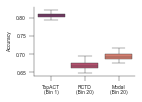

In [101]:
# Plot accuracy graph

sns.set(style="ticks", context='paper', font="Arial")
cm = 1/2.54  # centimeters in inches

plt.rcParams['figure.figsize'] = (4.6*cm, 3.23*cm)

b = sns.boxplot(data=df, x="Display", y="Accuracy", fill=True, palette='flare_r', hue='Display', linewidth=1*cm, showfliers=True, color='black')
b.set_xlabel("",fontsize=5)
b.set_ylabel("Accuracy",fontsize=5)
b.tick_params(labelsize=5)
# sns.stripplot(data=df, x="Display", y="Accuracy", s=1*cm, color='black')

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1*cm)
ax.spines['bottom'].set_linewidth(1*cm)
# ax.get_legend().remove()
ax.xaxis.set_tick_params(width=1*cm)
ax.yaxis.set_tick_params(width=1*cm)
plt.savefig('./accuracy.pdf', transparent='True', bbox_inches='tight')
plt.show()

In [91]:
np.std(topact_values, ddof=1) * 100

0.5979951688464015

In [92]:
np.mean(topact_values) * 100

80.755584

In [93]:
np.std(rctd_values, ddof=1) * 100

0.997711338185266

In [94]:
np.mean(rctd_values) * 100

66.78672

In [95]:
np.std(bin20_values, ddof=1) * 100

0.8726435944261148

In [96]:
np.mean(bin20_values) * 100

69.322944